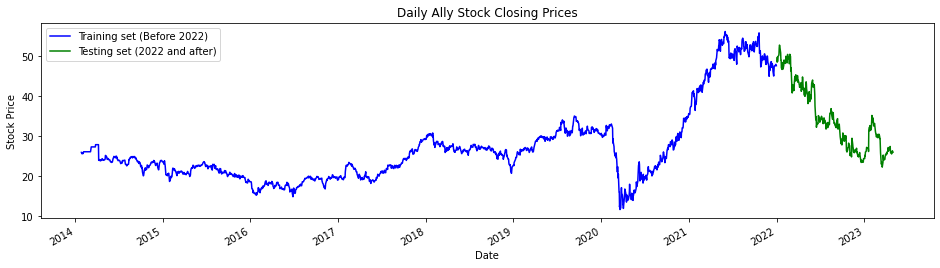

[[0.32103487 0.32103487 0.31383577 ... 0.27626547 0.2776153  0.28301462]
 [0.32103487 0.31383577 0.31383577 ... 0.2776153  0.28301462 0.28526434]
 [0.31383577 0.31383577 0.31383577 ... 0.28301462 0.28526434 0.28548931]
 ...
 [0.93273341 0.94263217 0.94465692 ... 0.8071991  0.80832396 0.8143982 ]
 [0.94263217 0.94465692 0.92823397 ... 0.80832396 0.8143982  0.81552306]
 [0.94465692 0.92823397 0.92913386 ... 0.8143982  0.81552306 0.80742407]]
Epoch 1/5
61/61 [==============================] - 2s 8ms/step - loss: 0.0521
Epoch 2/5
61/61 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 3/5
61/61 [==============================] - 0s 8ms/step - loss: 9.6273e-04
Epoch 4/5
61/61 [==============================] - 1s 10ms/step - loss: 8.2019e-04
Epoch 5/5
11/11 [==============================] - 0s 3ms/step
accuracy within 10%: 0.8829
accuracy within 15%: 0.9429
accuracy within 20%: 0.976


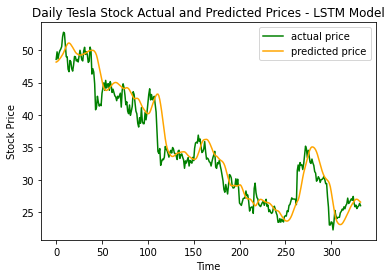

Epoch 1/5
61/61 [==============================] - 2s 12ms/step - loss: 0.0046
Epoch 2/5
61/61 [==============================] - 1s 14ms/step - loss: 3.1816e-04
Epoch 3/5
61/61 [==============================] - 1s 13ms/step - loss: 2.9646e-04
Epoch 4/5
61/61 [==============================] - 1s 13ms/step - loss: 2.9789e-04
Epoch 5/5
11/11 [==============================] - 0s 2ms/step
accuracy within 10%: 0.973
accuracy within 15%: 0.991
accuracy within 20%: 1


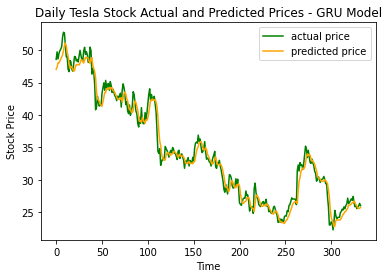

In [4]:
# Problem 1
import numpy
import pandas
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.random import set_seed

ally_data=pandas.read_csv(r"C:/Users/saedw/OneDrive/Desktop/STAT 574 Data Mining/hw4STAT574S23/DATA SETS/ALLY.csv", index_col="Date", parse_dates=["Date"])


# plot ally daily closing prices

time_start = 2010
time_end = 2021
ally_data.loc[f"{time_start}":f"{time_end}", "Close"].plot(figsize=(16, 4), color="blue", legend=True)
ally_data.loc[f"{time_end+1}":, "Close"].plot(figsize=(16, 4), color="green", legend=True)
plt.legend([f"Training set (Before {time_end+1})", f"Testing set ({time_end+1} and after)"])
plt.title("Daily Ally Stock Closing Prices")
plt.ylabel("Stock Price")
plt.show()  


#rescaling data
ally_data["Close_sc"]=(ally_data["Close"]-min(ally_data["Close"]))/(max(ally_data["Close"].values)-min(ally_data["Close"]))
train_set=ally_data.loc[f"{time_start}":f"{time_end}", "Close_sc"].values
test_set=ally_data.loc[f"{time_end+1}":, "Close_sc"].values


#splitting training data into samples
nsteps=60  #width of sliding window

def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return numpy.array(x), numpy.array(y)

train_x, train_y=split_sequence(train_set, nsteps)

print(train_x)

###############################################################
#FITTING LSTM MODEL
###############################################################
features=1 #predictors and response are the same variable
#reshaping train_x
train_x=train_x.reshape(train_x.shape[0], train_x.shape[1],features)

#specifying LSTM model architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=6, activation="tanh", input_shape=(nsteps, features)))
model_lstm.add(Dense(units=1))

#compiling the model
model_lstm.compile(loss="mse")
model_lstm.fit(train_x, train_y, epochs=5, batch_size=32)

#creating testing set by adding nsteps observations from training set to testing set
inputs=ally_data.loc[:,"Close_sc"][len(ally_data)-len(test_set)-nsteps:].values
inputs=inputs.reshape(-1, 1)

#splitting into samples
test_x, test_y=split_sequence(inputs, nsteps)

#reshaping
test_x=test_x.reshape(test_x.shape[0], test_x.shape[1], features)

#predicting for testing data
pred_y=model_lstm.predict(test_x)

#inverse transforming the values
pred_y=pred_y*(max(ally_data["Close"].values)-min(ally_data["Close"]))+min(ally_data["Close"])
test_y=test_y*(max(ally_data["Close"].values)-min(ally_data["Close"]))+min(ally_data["Close"])

#computing prediction accuracy
ind10=[]
ind15=[]
ind20=[]     

for sub1, sub2 in zip(pred_y, test_y):
    ind10.append(1) if abs(sub1-sub2)<0.10*sub2 else ind10.append(0)
    ind15.append(1) if abs(sub1-sub2)<0.15*sub2 else ind15.append(0)
    ind20.append(1) if abs(sub1-sub2)<0.20*sub2 else ind20.append(0)
   
print('accuracy within 10%:', round(mean(ind10),4))
print('accuracy within 15%:', round(mean(ind15),4))
print('accuracy within 20%:', round(mean(ind20),4))
    
#plotting actual and predicted values for testing data
plt.plot(test_y, color="green", label="actual price")
plt.plot(pred_y, color="orange", label="predicted price")
plt.title("Daily Tesla Stock Actual and Predicted Prices - LSTM Model")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
    
###############################################################
#FITTING GRU MODEL
###############################################################
#specifying GRU model architecture
model_gru = Sequential()
model_gru.add(GRU(units=6, activation="tanh", input_shape=(nsteps, features)))
model_gru.add(Dense(units=1))

# Compiling the model
model_gru.compile(loss="mse")
model_gru.fit(train_x, train_y, epochs=5, batch_size=32)

#predicting for testing data
pred_y=model_gru.predict(test_x)

#inverse transforming the values
pred_y=pred_y*(max(ally_data["Close"].values)-min(ally_data["Close"]))+min(ally_data["Close"])

#computing prediction accuracy
ind10=[]
ind15=[]
ind20=[]     

for sub1, sub2 in zip(pred_y, test_y):
    ind10.append(1) if abs(sub1-sub2)<0.10*sub2 else ind10.append(0)
    ind15.append(1) if abs(sub1-sub2)<0.15*sub2 else ind15.append(0)
    ind20.append(1) if abs(sub1-sub2)<0.20*sub2 else ind20.append(0)
   
print('accuracy within 10%:', round(mean(ind10),4))
print('accuracy within 15%:', round(mean(ind15),4))
print('accuracy within 20%:', round(mean(ind20),4))
    
#plotting actual and predicted values for testing data
plt.plot(test_y, color="green", label="actual price")
plt.plot(pred_y, color="orange", label="predicted price")
plt.title("Daily Tesla Stock Actual and Predicted Prices - GRU Model")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [ ]:
# Problem 2

# binary RNN (recurrent nueral network)

import numpy
import pandas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.random import set_seed

ally_data=pandas.read_csv(r"C:/Users/saedw/OneDrive/Desktop/STAT 574 Data Mining/hw4STAT574S23/DATA SETS/ALLY_shocks.csv", 
                          index_col="Date", parse_dates=["Date"])


#splitting into training and testing sets
time_start = 2010
time_end = 2021
def train_test_split(time_start, time_end):
    train=ally_data.loc[f"{time_start}":f"{time_end}", "Shock"].values
    test=ally_data.loc[f"{time_end+1}":, "Shock"].values
    return train, test

train_set, test_set = train_test_split(time_start, time_end)

#splitting training data into samples
nsteps = 60

def split_sequence(sequence):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_i = i + nsteps
        if end_i > len(sequence)-1:
            break
        seq_x, seq_y=sequence[i:end_i], sequence[end_i]
        x.append(seq_x)
        y.append(seq_y)
    return numpy.array(x), numpy.array(y)

train_x, train_y = split_sequence(train_set)

###############################################################
#FITTING LSTM MODEL
###############################################################
#reshaping train_x
features = 1
train_x=train_x.reshape(train_x.shape[0],train_x.shape[1],features)

#specifying model architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=6, activation="sigmoid", input_shape=(nsteps, features)))
model_lstm.add(Dense(units=1))

# Compiling the model
model_lstm.compile(loss="binary_crossentropy")
model_lstm.fit(train_x, train_y, epochs=5, batch_size=32)
inputs = ally_data.loc[:,"Shock"][len(ally_data.loc[:,"Shock"])-len(test_set)-nsteps :].values

#splitting into samples
test_x, test_y = split_sequence(inputs)

#reshaping
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], features)

#predicting for testing data
pred_prob=model_lstm.predict(test_x)

cutoff=[]
accuracy=[]
for i in range(99):
    tp=0
    tn=0
    cutoff.append(0.01*(i+1))
    for sub1, sub2 in zip(pred_prob, test_y):
        tp_ind=1 if (sub1>0.01*(i+1) and sub2==1) else 0
        tn_ind=1 if (sub1<0.01*(i+1) and sub2==0) else 0
        tp+=tp_ind
        tn+=tn_ind
    accuracy_i=(tp+tn)/len(pred_prob)
    accuracy.append(accuracy_i)
    
df=pandas.DataFrame({'accuracy': accuracy,'cut-off': cutoff})
max_accuracy=max(accuracy)
optimal=df[df['accuracy']==max_accuracy]
print(optimal)

###############################################################
#FITTING GRU MODEL
###############################################################
#specifying model architecture
model_gru = Sequential()
model_gru.add(GRU(units=6, activation="sigmoid", input_shape=(nsteps, features)))
model_gru.add(Dense(units=1))

# Compiling the model
model_gru.compile(loss="binary_crossentropy")
model_gru.fit(train_x, train_y, epochs=5, batch_size=32)

#predicting for testing data
pred_prob=model_lstm.predict(test_x)

cutoff=[]
accuracy=[]
for i in range(99):
    tp=0
    tn=0
    cutoff.append(0.01*(i+1))
    for sub1, sub2 in zip(pred_prob, test_y):
        tp_ind=1 if (sub1>0.01*(i+1) and sub2==1) else 0
        tn_ind=1 if (sub1<0.01*(i+1) and sub2==0) else 0
        tp+=tp_ind
        tn+=tn_ind
        
    accuracy_i=(tp+tn)/len(pred_prob)
    accuracy.append(accuracy_i)
    
df=pandas.DataFrame({'accuracy': accuracy,'cut-off': cutoff})
max_accuracy=max(accuracy)
optimal=df[df['accuracy']==max_accuracy]
print(optimal)


Epoch 1/5
61/61 [==============================] - 1s 8ms/step - loss: 1.0665
Epoch 2/5
61/61 [==============================] - 1s 8ms/step - loss: 1.0665
Epoch 3/5
61/61 [==============================] - 1s 9ms/step - loss: 1.0665
Epoch 4/5
61/61 [==============================] - 1s 9ms/step - loss: 1.0665
Epoch 5/5
11/11 [==============================] - 0s 2ms/step
    accuracy  cut-off
0   0.831832     0.01
1   0.831832     0.02
2   0.831832     0.03
3   0.831832     0.04
4   0.831832     0.05
..       ...      ...
94  0.831832     0.95
95  0.831832     0.96
96  0.831832     0.97
97  0.831832     0.98
98  0.831832     0.99

[99 rows x 2 columns]
Epoch 1/5
61/61 [==============================] - 2s 11ms/step - loss: 0.2904
Epoch 2/5
61/61 [==============================] - 1s 12ms/step - loss: 0.2718
Epoch 3/5
61/61 [==============================] - 1s 11ms/step - loss: 0.2576
Epoch 4/5
61/61 [==============================] - 1s 10ms/step - loss: 0.2470
Epoch 5/5
11/11 [=====

In [1]:
# Problem 3
# multinomial RNN

import numpy
import pandas
import matplotlib.pyplot as plt
from statistics import mean
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

weather=pandas.read_csv(r'C:/Users/saedw/OneDrive/Desktop/STAT 574 Data Mining/hw4STAT574S23/DATA SETS/weather_description.csv', 
index_col="Date", parse_dates=["Date"])


chicago_data = weather[['Chicago']]

# creating dummy variables
chicago_data=pandas.get_dummies(chicago_data['Chicago'])

display(chicago_data)
for col in chicago_data.columns:
    print(col)

#FITTING LSTM MODEL

######################################################
#Building Model for Rain
######################################################
#defining training and testing sets
time_start = 2012
time_end = 2016
def train_test_split(time_start, time_end):
    train=chicago_data.loc[f"{time_start}":f"{time_end}", "rain"].values
    test=chicago_data.loc[f"{time_end+1}":, "rain"].values
    return train, test
train_set, test_set = train_test_split(time_start, time_end)

#splitting training data into samples
nsteps = 60
def split_sequence(sequence):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_i = i + nsteps
        if end_i > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        x.append(seq_x)
        y.append(seq_y)
    return numpy.array(x), numpy.array(y)

train_x, train_y = split_sequence(train_set)

#reshaping train_x
features = 1
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],features)

#specifying LSTM model architecture
fitted_model = Sequential()
fitted_model.add(LSTM(units=6, activation="sigmoid", input_shape=(nsteps, features)))
fitted_model.add(Dense(units=1, activation="sigmoid"))

#compiling model
fitted_model.compile(loss="binary_crossentropy")
fitted_model.fit(train_x, train_y, epochs=5, batch_size=32)
inputs=chicago_data.loc[:,"rain"][len(chicago_data.loc[:,"rain"]) - len(test_set) - nsteps : ].values

#splitting into samples
test_x, test_rain = split_sequence(inputs)

#reshaping
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], features)

#predicting for testing data
pred_prob_rain = fitted_model.predict(test_x)


######################################################
#Building Model for Fog
######################################################
#defining training and testing sets
def train_test_split(time_start, time_end):
    train=chicago_data.loc[f"{time_start}":f"{time_end}", "fog"].values
    test=chicago_data.loc[f"{time_end+1}":, "fog"].values
    return train, test
train_set, test_set = train_test_split(time_start, time_end)

#splitting training data into samples
def split_sequence(sequence):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_i = i + nsteps
        if end_i > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        x.append(seq_x)
        y.append(seq_y)
    return numpy.array(x), numpy.array(y)

train_x, train_y = split_sequence(train_set)

#reshaping train_x
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],features)

#specifying LSTM model architecture
fitted_model = Sequential()
fitted_model.add(LSTM(units=6,  activation="sigmoid", input_shape=(nsteps, features)))
fitted_model.add(Dense(units=1, activation="sigmoid"))

#compiling model
fitted_model.compile(loss="binary_crossentropy")
fitted_model.fit(train_x, train_y, epochs=5, batch_size=32)
inputs=chicago_data.loc[:,"fog"][len(chicago_data.loc[:,"fog"]) - len(test_set) - nsteps : ].values

#splitting into samples
test_x, test_fog = split_sequence(inputs)

#reshaping
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], features)

#predicting for testing data
pred_prob_fog = fitted_model.predict(test_x)

######################################################
#Building Model for Clear
######################################################
#defining training and testing sets
def train_test_split(time_start, time_end):
    train=chicago_data.loc[f"{time_start}":f"{time_end}", "clear"].values
    test=chicago_data.loc[f"{time_end+1}":, "clear"].values
    return train, test
train_set, test_set = train_test_split(time_start, time_end)


#splitting training data into samples
def split_sequence(sequence):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_i = i + nsteps
        if end_i > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        x.append(seq_x)
        y.append(seq_y)
    return numpy.array(x), numpy.array(y)

train_x, train_y = split_sequence(train_set)

#reshaping train_x
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],features)

#specifying LSTM model architecture
fitted_model = Sequential()
fitted_model.add(LSTM(units=6,  activation="sigmoid", input_shape=(nsteps, features)))
fitted_model.add(Dense(units=1, activation="sigmoid"))

#compiling model
fitted_model.compile(loss="binary_crossentropy")
fitted_model.fit(train_x, train_y, epochs=5, batch_size=32)
inputs=chicago_data.loc[:,"clear"][len(chicago_data.loc[:,"clear"]) - len(test_set) - nsteps : ].values

#splitting into samples
test_x, test_clear = split_sequence(inputs)

#reshaping
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], features)

#predicting for testing data
pred_prob_clear = fitted_model.predict(test_x)

######################################################
#Building Model for Cloudy
######################################################
#defining training and testing sets
def train_test_split(time_start, time_end):
    train=chicago_data.loc[f"{time_start}":f"{time_end}", "cloudy"].values
    test=chicago_data.loc[f"{time_end+1}":, "cloudy"].values
    return train, test
train_set, test_set = train_test_split(time_start, time_end)

#splitting training data into samples
def split_sequence(sequence):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_i = i + nsteps
        if end_i > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        x.append(seq_x)
        y.append(seq_y)
    return numpy.array(x), numpy.array(y)

train_x, train_y = split_sequence(train_set)

#reshaping train_x
train_x = train_x.reshape(train_x.shape[0],train_x.shape[1],features)

#specifying LSTM model architecture
fitted_model = Sequential()
fitted_model.add(LSTM(units=6,  activation="sigmoid", input_shape=(nsteps, features)))
fitted_model.add(Dense(units=1, activation="sigmoid"))

#compiling model
fitted_model.compile(loss="binary_crossentropy")
fitted_model.fit(train_x, train_y, epochs=5, batch_size=32)
inputs=chicago_data.loc[:,"cloudy"][len(chicago_data.loc[:,"cloudy"]) - len(test_set) - nsteps : ].values

#splitting into samples
test_x, test_cloudy = split_sequence(inputs)

#reshaping
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], features)

#predicting for testing data
pred_prob_cloudy = fitted_model.predict(test_x)

#######################################################
#Computing Prediction Accuracy
#######################################################
pred_prob_all=numpy.concatenate((pred_prob_rain, pred_prob_fog,pred_prob_clear,pred_prob_cloudy), axis=1)
pred_prob_all=pandas.DataFrame(pred_prob_all)
pred_class=pred_prob_all.idxmax(axis=1)

test_all=numpy.c_[test_rain,test_fog, test_clear, test_cloudy]
test_all=pandas.DataFrame(test_all)
true_class=test_all.idxmax(axis=1)

match=[]
for i in range(len(pred_class)):
    if pred_class[i]==true_class[i]: 
            match.append(1)
    else:
            match.append(0)
        
print(round(mean(match),4))




,broken clouds,drizzle,dust,few clouds,fog,freezing rain,haze,heavy intensity drizzle,heavy intensity rain,heavy snow,...,smoke,snow,squalls,thunderstorm,thunderstorm with drizzle,thunderstorm with heavy rain,thunderstorm with light drizzle,thunderstorm with light rain,thunderstorm with rain,very heavy rain
Date,,,,,,,,,,,,,,,,,,,,,
2012-10-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-29,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-11-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-11-29,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


broken clouds
drizzle
dust
few clouds
fog
freezing rain
haze
heavy intensity drizzle
heavy intensity rain
heavy snow
light intensity drizzle
light rain
light rain and snow
light snow
mist
moderate rain
overcast clouds
proximity shower rain
proximity thunderstorm
proximity thunderstorm with drizzle
proximity thunderstorm with rain
scattered clouds
sky is clear
smoke
snow
squalls
thunderstorm
thunderstorm with drizzle
thunderstorm with heavy rain
thunderstorm with light drizzle
thunderstorm with light rain
thunderstorm with rain
very heavy rain


KeyError: 'rain'

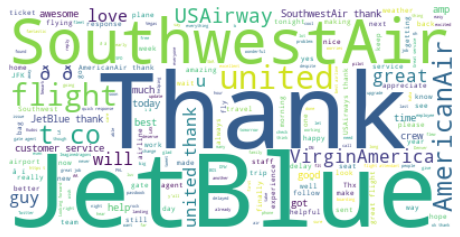

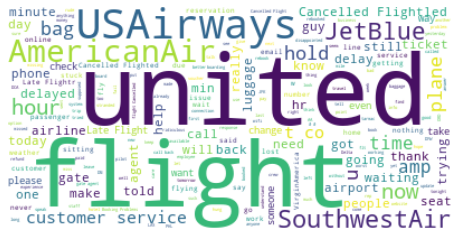

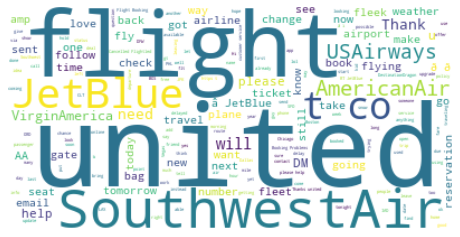

C:\Users\saedw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\saedw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\saedw\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To 

(188, 0.7357336065553605)

In [9]:
# Problem 7

# sentiment analysis


# part a)
#!pip install wordcloud
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud


data=pandas.read_csv(r"C:/Users/saedw/OneDrive/Desktop/STAT 574 Data Mining/hw4STAT574S23/DATA SETS/USAirlinesTweets.csv",encoding='ISO-8859-1')
data.drop_duplicates(subset=['tweet'],keep='first',inplace=True)
text = " ".join([x for x in data.tweet])

#plotting wordclouds for positive news
text = "".join([x for x in data.tweet[data.sentiment=='positive']])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


#plotting wordclouds for negative news
text = "".join([x for x in data.tweet[data.sentiment=='negative']])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# neutral
text = "".join([x for x in data.tweet[data.sentiment=='neutral']])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# part b)

#plotting bar graph for sentiments
# seaborn.countplot(data.sentiment)

#displaying frequency by sentiment
data['sentiment'].value_counts()

#training model
numpy.random.seed(5677934)
train, test = train_test_split(data,test_size = 0.2)

#!pip install simpletransformers
#!pip install torch

from simpletransformers.classification import ClassificationModel

# Create a TransformerModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, 
args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)

def making_label(st):
    if(st=='positive'):
        return 0
    elif(st=='neutral'):
        return 2
    else:
        return 1
    
train['label']=train['sentiment'].apply(making_label)
test['label']=test['sentiment'].apply(making_label)

train_df = pandas.DataFrame({
    'text': train['tweet'][:1500].replace(r'\n', ' ', regex=True),
    'label': train['label'][:1500]
})

eval_df = pandas.DataFrame({
    'text': test['tweet'][-400:].replace(r'\n', ' ', regex=True),
    'label': test['label'][-400:]
})

model.train_model(train_df)




C:\Users\saedw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
Running Evaluation: 100%|██████████| 50/50 [01:48<00:00,  2.16s/it]

[[ 50   9   4]
 [  3 244   7]
 [ 13  35  35]]


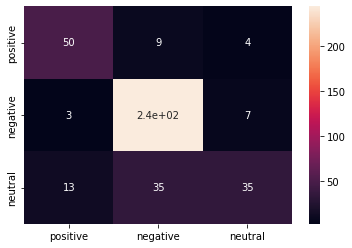

In [10]:
# Problem 7 part b continued

#computing predicted sentiments for testing set 
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

lst = []
for arr in model_outputs:
    lst.append(numpy.argmax(arr))
    
true = eval_df['label'].tolist()
predicted = lst

#displaying confusion matrix (positive/negative/neutral)
import sklearn
confmatrix = sklearn.metrics.confusion_matrix(true, predicted)
print(confmatrix)

#displaying heatmap for confusion matrix
df_cm = pandas.DataFrame(confmatrix, ['positive','negative','neutral'], ['positive','negative','neutral'])

seaborn.heatmap(df_cm, annot=True) 
plt.show()

In [11]:
#displaying performance metrics
sklearn.metrics.classification_report(true,predicted,target_names=['positive','negative','neutral'])

'              precision    recall  f1-score   support\n\n    positive       0.76      0.79      0.78        63\n    negative       0.85      0.96      0.90       254\n     neutral       0.76      0.42      0.54        83\n\n    accuracy                           0.82       400\n   macro avg       0.79      0.73      0.74       400\nweighted avg       0.82      0.82      0.81       400\n'

In [12]:
#computing predicted accuracy
sklearn.metrics.accuracy_score(true,predicted)

0.8225

In [13]:
#using the trained model to classify user-defined sentences
def classify(statement):
        result = model.predict([statement])
        pred_class = numpy.where(result[1][0] == numpy.amax(result[1][0]))
        pred_class = int(pred_class[0])
        sentiment_dict = {0:'positive',1:'negative',2:'neutral'}
        print(sentiment_dict[pred_class])
        return

classify('My terminal was changed.')
classify('The airline misplaced my luggage.')
classify('The economy seats were very comfortable.')

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


negative


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


negative


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

negative


In [ ]:
# problem 7 part c